In [1]:
import bilby as bb
import gwpopulation as gwpop
import matplotlib.pyplot as plt
import pandas as pd
from bilby.core.prior import PriorDict, Uniform
import os
import bilby
import numpy as np

In [2]:
#gwpop.set_backend("jax")

#xp = gwpop.utils.xp

project_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
#project_dir = '/home/divyajyoti.nln/Cardiff_University/Next_gen_detectability/A-sharp-study/'

In [3]:
#netw = 'Asharp'
netw = 'CE4020ET123'
#mass_band = 'below_40'
#mass_band = '40-80'
#mass_band = 'above_80'
#outdir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 
#                      netw, 'mass_bands', mass_band, 'run01_original_cov_mf_from_opt_SNR_injections_XPHM')
outdir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 
                      netw, 'run12_original_cov_mf_from_opt_SNR_injections_XPHM')

In [4]:
result = bilby.result.read_in_result(filename=os.path.join(outdir, f'{netw}_result.hdf5'))
#result = bilby.result.read_in_result(filename=os.path.join(outdir, 'CE4020ET123_result.hdf5'))

## Add the new parameter which is peak of the curve

In [5]:
def z_peak_new(gamma, kappa, z_peak):
    new_peak = (gamma/(kappa-gamma))**(1/kappa) * (1+z_peak) - 1
    return(new_peak)

In [6]:
true_params = {'gamma':1.8032, 'kappa':5.3023, 'z_peak':1.8362}
true_params['z_peak_new'] = z_peak_new(**true_params)

In [7]:
true_params

{'gamma': 1.8032,
 'kappa': 5.3023,
 'z_peak': 1.8362,
 'z_peak_new': 1.5028643466529545}

In [8]:
result.posterior

,gamma,kappa,log_likelihood,log_prior,z_peak
0,3.074419,5.537933,34070.082149,-5.857933,1.285767
1,3.053182,5.509510,34070.765801,-5.857933,1.229372
2,1.757943,5.381399,34071.017929,-5.857933,1.829136
3,1.804985,5.327532,34071.261943,-5.857933,1.947221
4,2.390817,5.091920,34071.468176,-5.857933,1.518036
...,...,...,...,...,...
3130,2.245569,5.292113,34079.770326,-5.857933,1.594075
3131,2.248252,5.280544,34079.772873,-5.857933,1.586881
3132,2.192949,5.249112,34079.774046,-5.857933,1.603716
3133,2.180953,5.254387,34079.775315,-5.857933,1.612974


In [9]:
z_peak_new_posterior = z_peak_new(result.posterior['gamma'], 
                                  result.posterior['kappa'], 
                                  result.posterior['z_peak'])

In [10]:
result.posterior.loc[:, 'z_peak_new'] = z_peak_new_posterior

In [11]:
result.posterior.sort_values('z_peak_new')

,gamma,kappa,log_likelihood,log_prior,z_peak,z_peak_new
1,3.053182,5.509510,34070.765801,-5.857933,1.229372,1.319148
9,3.051132,5.689131,34072.996320,-5.857933,1.275630,1.334577
71,2.528388,5.253667,34075.266020,-5.857933,1.374746,1.341090
46,2.828735,5.460010,34074.755791,-5.857933,1.311900,1.342744
38,2.920322,5.552003,34074.497572,-5.857933,1.300697,1.344230
...,...,...,...,...,...,...
40,1.957442,5.363768,34074.514314,-5.857933,1.845191,1.565992
24,2.055957,5.473624,34074.070671,-5.857933,1.815657,1.565998
22,1.704545,5.254944,34074.036696,-5.857933,1.954324,1.569309
8,2.057100,5.534658,34072.991547,-5.857933,1.830079,1.573950


### Remove outlier points if need be

In [13]:
result.posterior = result.posterior.sort_values('z_peak_new').dropna()
result.posterior

,gamma,kappa,log_likelihood,log_prior,z_peak,z_peak_new
140,0.004710,3.024756,347.125095,-5.857933,1.822008,-0.666928
68,0.021029,2.461712,346.484553,-5.857933,1.308225,-0.665374
71,0.047876,2.333894,346.508716,-5.857933,1.201876,-0.579845
84,0.175724,2.185053,346.634913,-5.857933,1.001152,-0.343884
184,0.082877,2.368170,347.288036,-5.857933,1.681441,-0.339169
...,...,...,...,...,...,...
79,0.310895,17.243456,346.559013,-5.857933,3.939700,2.917585
44,0.792745,11.796425,346.164868,-5.857933,3.900866,2.921295
103,0.515387,13.720777,346.884636,-5.857933,3.979622,2.931274
14,0.834912,15.941676,344.912980,-5.857933,3.750887,2.961790


In [14]:
ci99 = (result.posterior['z_peak_new'] > np.quantile(result.posterior['z_peak_new'], 0.99))
negative_vals = (result.posterior['z_peak_new'] < 0)
#drop_index = result.posterior[ci99 | negative_vals].index
drop_index = result.posterior[negative_vals].index

In [15]:
drop_index

Index([140,  68,  71,  84, 184, 421,   6, 170, 100, 128,  40, 417, 114, 141,
       182, 132, 301,   3, 359,  77, 134],
      dtype='int64')

In [16]:
result.posterior = result.posterior.drop(index=drop_index)
result.posterior

,gamma,kappa,log_likelihood,log_prior,z_peak,z_peak_new
325,0.032124,3.166125,347.768010,-5.857933,3.477664,0.053790
924,0.021812,4.147276,348.789539,-5.857933,2.769021,0.064753
108,0.345900,2.126269,346.908391,-5.857933,1.314030,0.070822
1215,0.014327,4.419923,349.027382,-5.857933,3.131998,0.130553
429,0.120672,2.848198,348.063445,-5.857933,2.395053,0.136060
...,...,...,...,...,...,...
79,0.310895,17.243456,346.559013,-5.857933,3.939700,2.917585
44,0.792745,11.796425,346.164868,-5.857933,3.900866,2.921295
103,0.515387,13.720777,346.884636,-5.857933,3.979622,2.931274
14,0.834912,15.941676,344.912980,-5.857933,3.750887,2.961790


### Plot corner

In [12]:
true_params

{'gamma': 1.8032,
 'kappa': 5.3023,
 'z_peak': 1.8362,
 'z_peak_new': 1.5028643466529545}

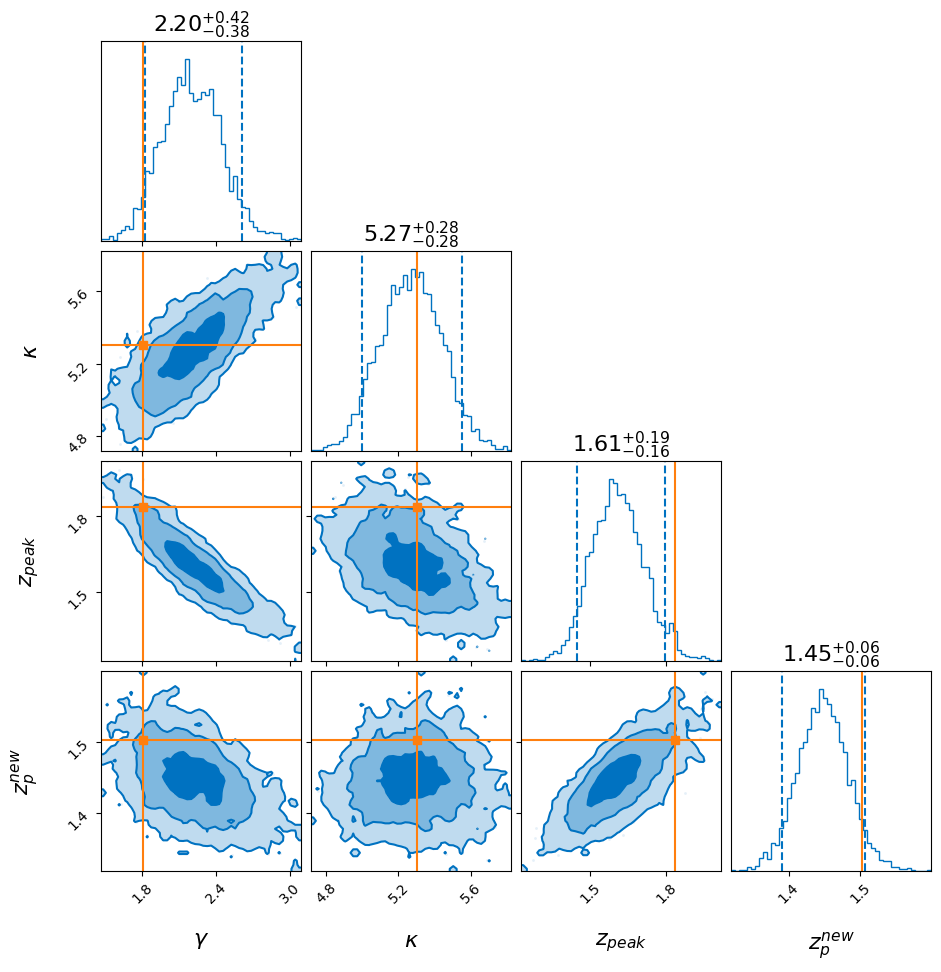

In [13]:
#result.plot_corner(parameters=list(true_params.keys()), outdir=outdir)
filename = f'{netw}_corner_with_truths.png'
#filename = 'CE4020ET123_corner_with_truths.png'
result.plot_corner(parameters=true_params, outdir=outdir, 
                   quantiles=(0.05, 0.95), 
                   filename=os.path.join(outdir, filename), labels=['$\\gamma$', '$\\kappa$', '$z_{peak}$', '$z_{p}^{new}$'])

## Calculate variance

In [19]:
gwpop.set_backend("jax")
from gwpopulation.experimental.jax import JittedLikelihood, NonCachingModel
import jax

xp = gwpop.utils.xp

project_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
#project_dir = '/home/divyajyoti.nln/Cardiff_University/Next_gen_detectability/A-sharp-study/'

/home/divyajyoti/miniconda3/envs/gwpopulation/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/divyajyoti/miniconda3/envs/gwpopulation/lib/python3.11/site-packages/htcondor/__init__.py:49: UserWarning: Neither the environment variable CONDOR_CONFIG, /etc/condor/, /usr/local/etc/, nor ~condor/ contain a condor_config source. Therefore, we are using a null condor_config.
  _warnings.warn(message)


In [22]:
#netw = 'Asharp'
netw = 'CE4020ET123'
#mass_band = 'below_40'
#mass_band = '40-80'
mass_band = 'above_80'
outdir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 
                      netw, 'mass_bands', mass_band, 'run01_original_cov_mf_from_opt_SNR_injections_XPHM')
#outdir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 
#                      netw, 'run09_original_cov_mf_from_opt_SNR_injections_XPHM')

In [23]:
result = bilby.result.read_in_result(filename=os.path.join(outdir, f'{netw}_result.hdf5'))
#result = bilby.result.read_in_result(filename=os.path.join(outdir, 'CE4020ET123_result.hdf5'))

In [24]:
with open(os.path.join(outdir, 'README.txt'), 'r') as f:
    lines = [line.rstrip('\n').strip('\t') for line in f]
readme_dict = {}
for line in lines:
    words = line.split()
    if 'Posterior' in words:
        readme_dict['posterior_file'] = words[-1].replace('divyajyoti.nln/', 'divyajyoti/ACADEMIC/Projects/')
    elif 'Injections' in words:
        readme_dict['injections_file'] = words[-1].replace('divyajyoti.nln/', 'divyajyoti/ACADEMIC/Projects/')

In [25]:
readme_dict

{'posterior_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/mass_bands/CE4020ET123_CoBA10_2_PLP_z_MD_zmax_10_lmrd_22_no_spins_set3_z_posteriors_original_cov_49_events_pop_from_XPHM_above_80.pkl',
 'injections_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/injections/mass_bands/XPHM/CE4020ET123_CoBA10_SNR_2_pop_PLP_spin_prec_z_MD_zmax_10_lmrd_22_corrected_td_detected_injs_mf_from_opt_SNR_19852_points_above_80.pkl'}

In [26]:
# ## Load posteriors
posteriors = pd.read_pickle(readme_dict['posterior_file'])

In [127]:
# ## Load injections

import dill
from tqdm import tqdm

with open(readme_dict['injections_file'], "rb") as ff:
    injections = dill.load(ff)

In [128]:
z_max = 10
model = NonCachingModel(
    model_functions=[gwpop.models.redshift.MadauDickinsonRedshift(cosmo_model="Planck18", z_max=z_max)],
    #model_functions=[gwpop.models.redshift.PowerLawRedshift(z_max=8)],
)

vt = gwpop.vt.ResamplingVT(model=model, data=injections, n_events=len(posteriors))

likelihood = gwpop.hyperpe.HyperparameterLikelihood(
    posteriors=posteriors,
    hyper_prior=model,
    selection_function=vt,
)

priors = PriorDict()
priors['gamma'] = Uniform(minimum=0, maximum=5, latex_label="$\\gamma$")
priors['kappa'] = Uniform(minimum=0, maximum=20, latex_label="$\\kappa$")
priors['z_peak'] = Uniform(minimum=0.5, maximum=4, latex_label="$z_{peak}$")

parameters = priors.sample()
likelihood.parameters.update(parameters)

In [131]:
likelihood.ln_likelihood_and_variance?

Signature: likelihood.ln_likelihood_and_variance()
Docstring: Compute the ln likelihood estimator and its variance.
File:      ~/miniconda3/envs/gwpopulation/lib/python3.11/site-packages/gwpopulation/hyperpe.py
Type:      method

In [30]:
func = jax.jit(likelihood.generate_extra_statistics)
#func = jax.jit(likelihood.ln_likelihood_and_variance)

In [43]:
test_full_posterior_list = [func(parameters) for parameters in tqdm(result.posterior.to_dict(orient="records"), desc='constructing full posterior')]
test_full_posterior = pd.DataFrame(test_full_posterior_list).astype(float)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2726/2726 [00:15<00:00, 171.65it/s]


In [58]:
len(test_full_posterior_list)

2726

In [118]:
import numpy as np

keys_ln_bf = []
keys_var_event = []
keys_main = []
for key in test_full_posterior_list[0].keys():
    if 'ln_bf' in key:
        keys_ln_bf.append(key)
    elif 'var_' in key:
        keys_var_event.append(key)
    else:
        keys_main.append(key)
keys_ln_bf.extend(keys_main)
keys_var_event.extend(keys_main)
"""
# Convert keys to list of indices (functions) to avoid repeated lookups
extractors_ln_bf     = [lambda d, k=k: d[k] for k in keys_ln_bf]
extractors_var_event = [lambda d, k=k: d[k] for k in keys_var_event]
extractors_main      = [lambda d, k=k: d[k] for k in keys_main]

# Preallocate arrays
N = len(test_full_posterior_list)
data_ln_bf     = np.empty((N, len(keys_ln_bf)), dtype=np.float32)
data_var_event = np.empty((N, len(keys_var_event)), dtype=np.float32)
data_main      = np.empty((N, len(keys_main)), dtype=np.float32)

# Fill arrays using extractors
for i, d in tqdm(enumerate(test_full_posterior_list), total=N, desc='Converting to arrays'):
    data_ln_bf[i]     = [f(d) for f in extractors_ln_bf]
    data_var_event[i] = [f(d) for f in extractors_var_event]
    data_main[i]      = [f(d) for f in extractors_main]

# Vectorized conversion to dict of arrays
dict_ln_bf     = dict(zip(keys_ln_bf,     data_ln_bf.T))
dict_var_event = dict(zip(keys_var_event, data_var_event.T))
dict_main      = dict(zip(keys_main,      data_main.T))

"""
data_ln_bf = np.empty((len(test_full_posterior_list), len(keys_ln_bf)), dtype=np.float32)
data_var_event = np.empty((len(test_full_posterior_list), len(keys_var_event)), dtype=np.float32)
data_main = np.empty((len(test_full_posterior_list), len(keys_main)), dtype=np.float32)

for i, d in tqdm(enumerate(test_full_posterior_list), total=len(test_full_posterior_list), desc='Converting to dictionaries'):
    data_ln_bf[i] = [d[k] for k in keys_ln_bf]
    data_var_event[i] = [d[k] for k in keys_var_event]
    data_main[i] = [d[k] for k in keys_main]

# Convert to dict of arrays
dict_ln_bf = {k: data_ln_bf[:, i] for i, k in enumerate(keys_ln_bf)}
dict_var_event = {k: data_var_event[:, i] for i, k in enumerate(keys_var_event)}
dict_main = {k: data_main[:, i] for i, k in enumerate(keys_main)}

Converting to dictionaries: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2726/2726 [00:01<00:00, 1526.93it/s]


In [108]:
df_main = pd.DataFrame(dict_main)

In [109]:
df_main.describe()

,gamma,kappa,log_likelihood,log_prior,selection,selection_variance,variance,z_peak
count,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2.726000e+03,2726.000000,2726.000000
mean,1.907401,5.996839,348.920807,-5.857933,0.999426,2.852150e-06,0.006922,2.068088
std,1.418292,1.680055,0.973480,0.000000,0.001255,2.823121e-06,0.006776,0.851838
min,0.000085,2.126269,340.495758,-5.857933,0.995153,3.261948e-08,0.000150,0.505977
25%,0.687937,4.923723,348.497223,-5.857933,0.998645,1.178110e-06,0.002897,1.354990
50%,1.576846,5.878192,349.140945,-5.857933,0.999521,2.046581e-06,0.004986,1.916559
75%,2.985056,6.878242,349.599495,-5.857933,1.000288,3.619512e-06,0.008758,2.738614
max,4.998580,17.243456,350.289764,-5.857933,1.003706,3.582271e-05,0.086029,3.999785


In [113]:
df_main[result.search_parameter_keys + ["log_likelihood", "variance"]].corr()

,gamma,kappa,z_peak,log_likelihood,variance
gamma,1.000000,0.198562,-0.804147,0.311881,-0.050510
kappa,0.198562,1.000000,0.250383,-0.164009,-0.004891
z_peak,-0.804147,0.250383,1.000000,-0.320078,0.032138
log_likelihood,0.311881,-0.164009,-0.320078,1.000000,-0.807387
variance,-0.050510,-0.004891,0.032138,-0.807387,1.000000


### Save to files

In [112]:
import h5py
with h5py.File(os.path.join(outdir, 'ln_bf_vals_events.h5'), 'w') as f:
    for key, array in dict_ln_bf.items():
        f.create_dataset(key, data=array)

with h5py.File(os.path.join(outdir, 'var_vals_events.h5'), 'w') as f:
    for key, array in dict_var_event.items():
        f.create_dataset(key, data=array)

In [114]:
df_main.to_csv(os.path.join(outdir, 'full_posterior_main.csv'))

### Plot the scatter matrix

In [115]:
pd.plotting.scatter_matrix(
    df_main[["gamma", "kappa", "z_peak", "log_likelihood", "variance"]],
    alpha=0.5,
)
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'param_variance_matrix.png'), dpi=300)